## CoIP vs. Predicted
In this notebook, we'll generate a plot of the fold change from a CoIP experiment against the confidence and RMSD sums from AlphaFold predictions.

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import r2_score
import statsmodels.api as sm
from scipy.stats import ttest_ind, linregress
from os import listdir
from os.path import isdir
import json
import tqdm

## Read in the data
We need both the CoIP data and the RMSD analysis output.

In [2]:
enriched = pd.read_excel('/mnt/research/Walker_Lab_Research/Serena_project_data/alpha_utility_data/data/anne/CmerolaeCoIP_WistarProteomics.xlsx', sheet_name='141 Enriched proteins')[['Accession', 'Fold Change CM_vs_CMC']]
enriched.head()

,Accession,Fold Change CM_vs_CMC
0,CMH170CT,3910.855425
1,CML232CT,522.354930
2,CMR341CT,195.389464
3,CMJ081CT,122.542684
4,CMD011CT,106.298454


In [17]:
confidences = pd.read_csv('/mnt/research/Walker_Lab_Research/Serena_project_data/alpha_utility_data/data/anne/alphafold_outputs/30Apr2025/30Apr2025_rmsd_analysis.csv')
confidences.head()

,name,meanconfidence,rmsdsum
0,gnlcmercma041c_rubisco,0.804319,228.873631
1,gnlcmercmb102c_rubisco,0.801470,201.291355
2,gnlcmercmb148c_rubisco,0.892476,123.245080
3,gnlcmercmc011c_rubisco,0.715391,406.589266
4,gnlcmercmc066c_rubisco,0.822781,153.923192


## Data wrangling
We need to match the ID's from the CoIP experiment to the names of our AlphaFold outputs. This should be as easy as removing the `gnlcmer` and `_rubisco` from the AlphaFold ID's and adding a `T` to the end.

In [18]:
confidences['Accession'] = confidences['name'].str.split('_').str[0].str[7:].str.upper() + 'T'
confidences.head()

,name,meanconfidence,rmsdsum,Accession
0,gnlcmercma041c_rubisco,0.804319,228.873631,CMA041CT
1,gnlcmercmb102c_rubisco,0.801470,201.291355,CMB102CT
2,gnlcmercmb148c_rubisco,0.892476,123.245080,CMB148CT
3,gnlcmercmc011c_rubisco,0.715391,406.589266,CMC011CT
4,gnlcmercmc066c_rubisco,0.822781,153.923192,CMC066CT


Let's make sure they correspond:

In [19]:
len(set(confidences.Accession.tolist())), len(set(enriched.Accession.tolist())), len(set(confidences.Accession.tolist()).intersection(set(enriched.Accession.tolist())))

(140, 141, 140)

Looks like our confidences is missing a protein -- this could have happened when we ran the AlphaFold predictions, so we should go back and check there. For now, we'll move on, and combine the two datasets with an inner join.

In [20]:
to_plot = confidences.drop(columns=['name']).merge(enriched, left_on='Accession', right_on='Accession', how='inner')
to_plot.head()

,meanconfidence,rmsdsum,Accession,Fold Change CM_vs_CMC
0,0.804319,228.873631,CMA041CT,3.801790
1,0.801470,201.291355,CMB102CT,3.675339
2,0.892476,123.245080,CMB148CT,14.986511
3,0.715391,406.589266,CMC011CT,3.564322
4,0.822781,153.923192,CMC066CT,3.224364


Now drop any negative confidence values:

In [21]:
to_plot = to_plot[to_plot['meanconfidence'] > 0]
print(f'There are {len(to_plot)} rows after cleaning.')

There are 137 rows after cleaning.


## Plot
We're going to make separate 2D plots as well as a 3D plot combining the RMSD and confidence comparisons.

### Confidence

Text(0, 0.5, 'CoIP Fold Change')

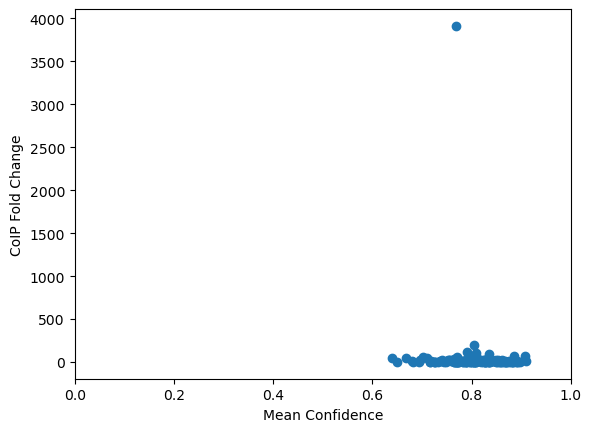

In [22]:
plt.scatter(to_plot.meanconfidence, to_plot['Fold Change CM_vs_CMC'])
plt.xlim(0, 1)
plt.xlabel('Mean Confidence')
plt.ylabel('CoIP Fold Change')

The range of fold changes makes this plot difficult to interpret; let's plot the y-axis on a log scale.

Text(0, 0.5, 'log2(CoIP Fold Change)')

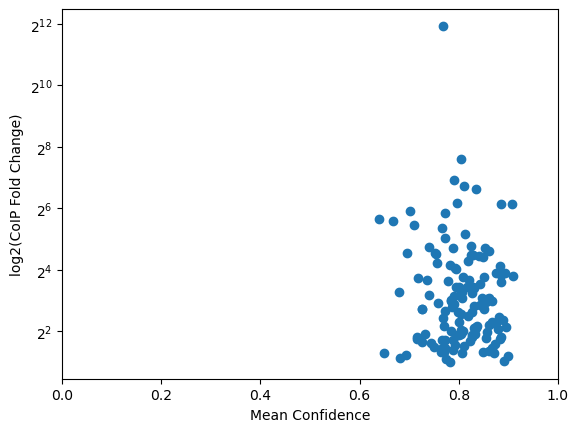

In [23]:
plt.semilogy(to_plot.meanconfidence, to_plot['Fold Change CM_vs_CMC'],'o', base=2)
plt.xlim(0, 1)
plt.xlabel('Mean Confidence')
plt.ylabel('log2(CoIP Fold Change)')

### RMSD

In [ ]:
plt.semilogy(to_plot.rmsdsum, to_plot['Fold Change CM_vs_CMC'], 'o', base=2)
plt.xlim(xmin=0)
plt.xlabel('RMSD Sum')
plt.ylabel('log2(CoIP Fold Change)')

### 3D combined plot
Apparently, there's no [good solution for logging an axis in 3D](https://stackoverflow.com/a/17363073) with matplotlib. We'll do the easy thing and apply the log to the column in question before plotting.

In [12]:
to_plot['log10_fold_change'] = np.log2(to_plot['Fold Change CM_vs_CMC'])

Text(0.5, 0, 'log10(CoIP Fold Change)')

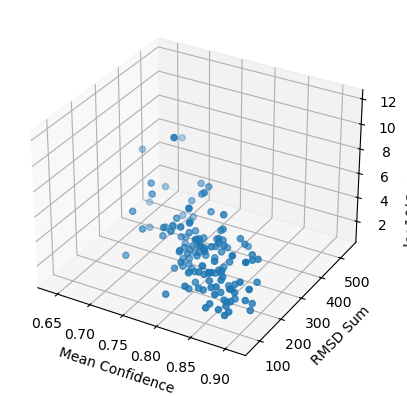

In [13]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

ax.scatter(to_plot['meanconfidence'], to_plot['rmsdsum'], to_plot['log10_fold_change'], marker='o')
ax.set_xlabel('Mean Confidence')
ax.set_ylabel('RMSD Sum')
ax.set_zlabel('log10(CoIP Fold Change)')

## Comparing to a random subset
We also want to make these graphs for a random subset of 141 proteins, to make sure that the high confidences for the coIP targets isn't an artefact of the way AlphaFold makes predictions.

In [4]:
random = pd.read_csv('/mnt/research/Walker_Lab_Research/Serena_project_data/alpha_utility_data/data/anne/alphafold_outputs/16Jun2025_analysis_rmsd_analysis.csv')
random.head()

,name,meanconfidence,rmsdsum
0,gnlcmercma025c_rubisco_20250617_162400,0.816996,267.393368
1,gnlcmercma061c_rubisco_20250617_162400,0.754322,284.407250
2,gnlcmercma078c_rubisco_20250617_162400,0.921492,112.502628
3,gnlcmercma083c_rubisco_20250617_162357,0.787599,181.417870
4,gnlcmercma135c_rubisco_20250617_162357,0.801609,204.771320


Check for overlap with the actual subset (I didn't rule out proteins from the original in my sampling):

In [9]:
random_partners = set(random.name.str.split('_', expand=True)[0])
original_partners = set(confidences.name.str.split('_', expand=True)[0])
print(len(random_partners), len(original_partners), len(random_partners.intersection(original_partners)))

139 140 3


Only 3 overlap! We can't make the same plots that we did for the actual set, because we don't have coIP data for them; however, we can make a historgram of the confidences and RMSD and compare those to a histogram of the actual set to see if they're meaningfully different.

First, drop rows with confidence < 0, means that ALphaFold exploded on them:

In [11]:
confidences = confidences[confidences['meanconfidence'] > 0]
random = random[random['meanconfidence'] > 0]

In [13]:
random

,name,meanconfidence,rmsdsum
0,gnlcmercma025c_rubisco_20250617_162400,0.816996,267.393368
1,gnlcmercma061c_rubisco_20250617_162400,0.754322,284.407250
2,gnlcmercma078c_rubisco_20250617_162400,0.921492,112.502628
3,gnlcmercma083c_rubisco_20250617_162357,0.787599,181.417870
4,gnlcmercma135c_rubisco_20250617_162357,0.801609,204.771320
...,...,...,...
134,gnlcmercmt522c_rubisco_20250617_221502,0.832909,210.320735
135,gnlcmercmt537c_rubisco_20250617_221500,0.747385,54.318230
136,gnlcmercmt565c_rubisco_20250617_221500,0.784163,263.266426
137,gnlcmercmv019c_rubisco_20250617_221500,0.652489,345.062643


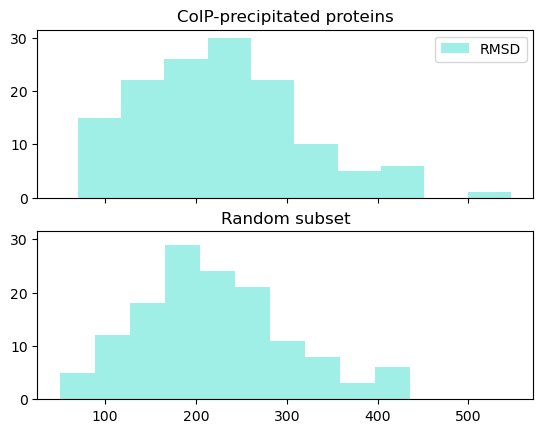

In [21]:
fig, axs = plt.subplots(2, 1, sharex=True, sharey=True)

axs[0].hist(confidences.rmsdsum, color='turquoise', alpha=0.5, label='RMSD')
axs[0].set_title('CoIP-precipitated proteins')

axs[1].hist(random.rmsdsum, color='turquoise', alpha=0.5, label='RMSD')
axs[1].set_title('Random subset')

axs[0].legend()

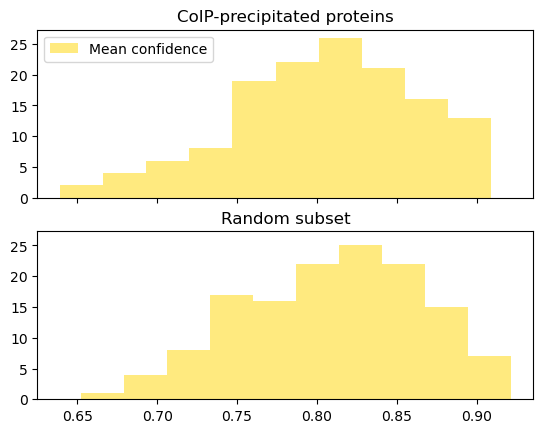

In [20]:
fig, axs = plt.subplots(2, 1, sharex=True, sharey=True)

axs[0].hist(confidences.meanconfidence, color='gold', alpha=0.5, label='Mean confidence')
axs[0].set_title('CoIP-precipitated proteins')

axs[1].hist(random.meanconfidence, color='gold', alpha=0.5, label='Mean confidence')
axs[1].set_title('Random subset')

axs[0].legend()

The confidences are clearly not meaningully different; but possibly the RMSD is, let's do a statistical test to check:

In [26]:
# Check normality -- they look good!
# sm.qqplot(confidences.rmsdsum, line='s')
# sm.qqplot(random.rmsdsum, line='s')

In [27]:
ttest_ind(confidences.rmsdsum, random.rmsdsum)

TtestResult(statistic=0.567233879159336, pvalue=0.5710231271896987, df=272.0)

## Testing impact of symmetry on RMSD
Rubisco is a D4 symmetrical protein, meaning there are 8 rotations/reflections that result in an identical protein. This means that there are multiple identical faces to which a given interactor could dock -- but docking at a different interface would cause the RMSD to artificially inflate. We hypothesized this is responsible for the lack of difference between the CoIP proteins and the randomly selected ones, so we implemented a set of rotations and took the minimum RMSD for each set of folds. We also added using mean and median as summary statistics for the RMSD instead of just sum -- so now we can compare all 3 metrics for the minimized RMSDs and see if we see a difference between the CoIP and random proteins.

In [46]:
rmsd_summaries = {
    'coIP': pd.read_csv('/mnt/research/Walker_Lab_Research/Serena_project_data/alpha_utility_data/data/anne/alphafold_outputs/30Apr2025_analysis_with_symmetry_rmsd_analysis.csv'),
    'random': pd.read_csv('/mnt/research/Walker_Lab_Research/Serena_project_data/alpha_utility_data/data/anne/alphafold_outputs/16Jun2025_analysis_with_symmetry_rmsd_analysis.csv')
}

Before anything, let's compare the distributions of the RMSD sum for the previous calculation and the symmetry-corrected one:

Text(0.5, 0.98, 'Impact of symmetry correction, p-value: 0.00')

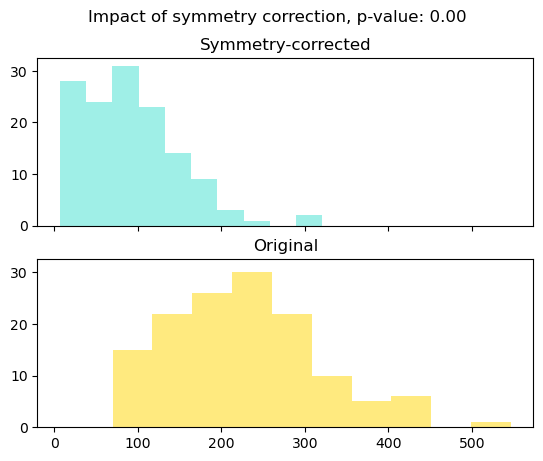

In [48]:
fig, axs = plt.subplots(2, 1, sharex=True, sharey=True)

axs[0].hist(rmsd_summaries['coIP']['rmsd_sum'], color='turquoise', alpha=0.5, label=stat)
axs[0].set_title('Symmetry-corrected')

axs[1].hist(to_plot.rmsdsum, color='gold', alpha=0.5, label=stat)
axs[1].set_title('Original')

pval = ttest_ind(rmsd_summaries['coIP']['rmsd_sum'], to_plot.rmsdsum).pvalue

fig.suptitle(f'Impact of symmetry correction, p-value: {pval:.2f}')

It really did make a difference! Next, let's plot a scatter of the fold change against the RMSD metrics for the proteins pulled down in the CoIP experiment:

Text(0.02, 0.5, 'log2(CoIP Fold Change)')

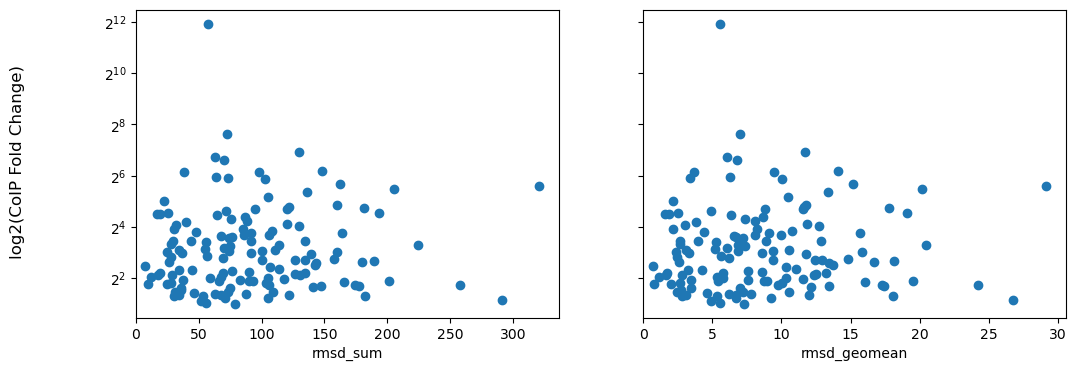

In [51]:
rmsd_summaries['coIP']['Accession'] = rmsd_summaries['coIP']['name'].str.split('_').str[0].str[7:].str.upper() + 'T'
coIP_with_fc = rmsd_summaries['coIP'].drop(columns=['name']).merge(enriched, left_on='Accession', right_on='Accession', how='inner')

fig, axs = plt.subplots(1, 2, sharey=True, figsize=(12, 4))

for stat, ax in zip(['rmsd_sum', 'rmsd_geomean'], axs):
    ax.semilogy(coIP_with_fc[stat], coIP_with_fc['Fold Change CM_vs_CMC'], 'o', base=2)
    ax.set_xlim(xmin=0)
    ax.set_xlabel(stat)
    
fig.supylabel('log2(CoIP Fold Change)')

Looks a tad more correlated than the original -- but let's check the $r^{2}$ values:

In [52]:
for stat in ['rmsd_sum', 'rmsd_geomean']:
    slope, intercept, r_value, p_value, std_err = linregress(coIP_with_fc[stat], np.log2(coIP_with_fc['Fold Change CM_vs_CMC']))
    r2 = r_value**2
    print(f'The correlation r-squared for the symmetry-corrected statistics {stat} is {r2:.3f}')

The correlation r-squared for the symmetry-corrected statistics rmsd_sum is 0.002
The correlation r-squared for the symmetry-corrected statistics rmsd_geomean is 0.001


In [53]:
slope, intercept, r_value, p_value, std_err = linregress(to_plot['rmsdsum'], np.log2(to_plot['Fold Change CM_vs_CMC']))
r2 = r_value**2
print(f'The correlation r-squared for the original rmsdsum is {r2:.3f}')

The correlation r-squared for the original rmsdsum is 0.000


Ok so, marginally better! But likely not enough to be meaningful. Let's take a look at the comparison between the CoIP and random proteins' distributions for these values:

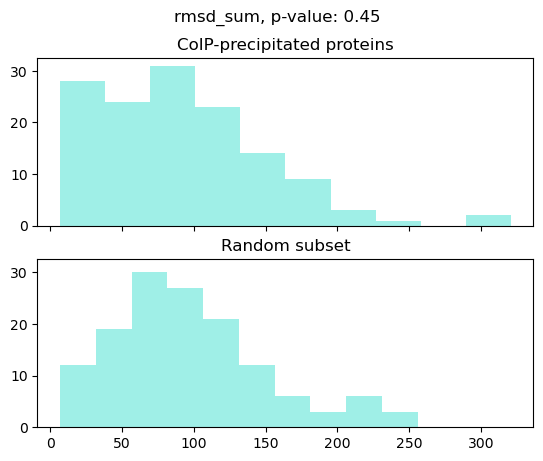

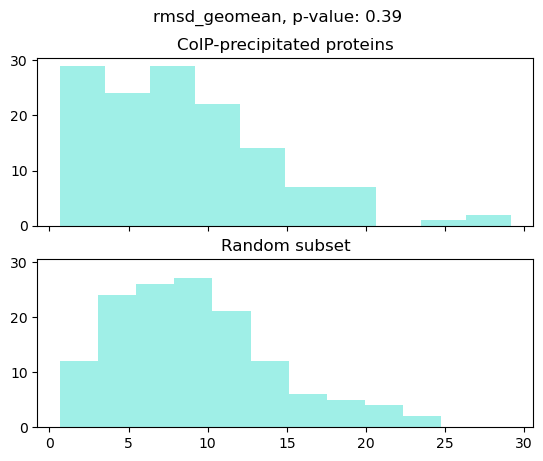

In [54]:
for stat in ['rmsd_sum', 'rmsd_geomean']:

    fig, axs = plt.subplots(2, 1, sharex=True, sharey=True)

    axs[0].hist(rmsd_summaries['coIP'][stat], color='turquoise', alpha=0.5, label=stat)
    axs[0].set_title('CoIP-precipitated proteins')
    
    axs[1].hist(rmsd_summaries['random'][stat], color='turquoise', alpha=0.5, label=stat)
    axs[1].set_title('Random subset')

    pval = ttest_ind(rmsd_summaries['coIP'][stat], rmsd_summaries['random'][stat]).pvalue

    fig.suptitle(f'{stat}, p-value: {pval:.2f}')

Looks like correcting for symmetry doesn't make the RMSD any better at discriminating between CoIP and random proteins.

## Using other metrics
AlphaFold does calculate [several other metrics](https://alphafoldserver.com/faq#how-do-i-interpret-all-the-outputs-in-the-downloaded-json-files) that may be more useful than the RMSD -- let's take a look at these 3:
1. **chain_iptm**: A [num_chains] array that gives the average confidence (interface pTM) in the interface between each chain and all other chains. Can be used for ranking a specific chain, when you care about where the chain binds to the rest of the complex and you do not know which other chains you expect it to interact with. This is often the case with ligands.
2. **chain_pair_iptm**: A [num_chains, num_chains] array. Off-diagonal element (i, j) of the array contains the ipTM restricted to tokens from chains i and j. Diagonal element (i, i) contains the pTM restricted to chain i. Can be used for ranking a specific interface between two chains, when you know that they interact, e.g. for antibody-antigen interactions
3. **chain_pair_pae_min**: A [num_chains, num_chains] array. Element (i, j) of the array contains the lowest PAE value across rows restricted to chain i and columns restricted to chain j. This has been found to correlate with whether two chains interact or not, and in some cases can be used to distinguish binders from non-binders. 

In [21]:
results_dir = '/mnt/research/Walker_Lab_Research/Serena_project_data/alpha_utility_data/data/anne/alphafold_outputs/30Apr2025/parallel/'
summary_confidence_dicts = {}
for elt in listdir(results_dir):
    if isdir(f'{results_dir}/{elt}'):
        try:
            with open(f'{results_dir}/{elt}/{elt}_summary_confidences.json') as f:
                summary_confidence_dicts[elt] = json.load(f)
        except FileNotFoundError:
            print('Failed run: ', list(listdir(f'{results_dir}/{elt}')))

Failed run:  ['gnlcmercmi059c_rubisco_data.json', 'gnlcmercmi059c_rubisco_20250506_204050']
Failed run:  ['gnlcmercme126c_rubisco_20250505_160931', 'gnlcmercme126c_rubisco_data.json']
Failed run:  ['gnlcmercml232c_rubisco_data.json']
Failed run:  ['gnlcmercme031c_rubisco_data.json', 'gnlcmercme031c_rubisco_20250505_144617']
Failed run:  ['gnlcmercmd109c_rubisco_20250505_132616', 'gnlcmercmd109c_rubisco_data.json']
Failed run:  ['gnlcmercmd108c_rubisco_20250505_120912', 'gnlcmercmd108c_rubisco_data.json']


In [18]:
random_results_dir = '/mnt/research/Walker_Lab_Research/Serena_project_data/alpha_utility_data/data/anne/alphafold_outputs/16June2025'
random_summary_confidence_dicts = {}
for elt in listdir(random_results_dir):
    if isdir(f'{random_results_dir}/{elt}') and len(elt.split('_')) == 4:
        shorthand_elt = '_'.join(elt.split('_')[:2])
        try:
            with open(f'{random_results_dir}/{elt}/{shorthand_elt}_summary_confidences.json') as f:
                random_summary_confidence_dicts[shorthand_elt] = json.load(f)
        except FileNotFoundError:
            print(list(listdir(f'{random_results_dir}/{elt}')))

['gnlcmercma053c_rubisco_data.json']


In [20]:
print(f'We have results for {len(summary_confidence_dicts)} CoIP proteins and {len(random_summary_confidence_dicts)} random proteins.')

We have results for 135 CoIP proteins and 139 random proteins.


We need to summarize the metrics that are on a chain pair basis in order to have a single score to comapre between folds. We only care that the partner chain interacts with any of the rubisco chains, so we'll take the maximum value from the row corresponding to that chain, ignoring the interaction with itself. In our dataset, the interactor with rubisco is always A (and for monomer-monomer interactions, this wouldn't matter).

In [26]:
def get_max_pair_metric(summary, metric):
    """
    Get the maximum value of the interaction of chain A with other chains.

    parameters:
        summary, dict: the summary_confidences.json file for this fold
        metric, str: key to summary dict for metric to look at

    returns:
        maxMetric, float: maximum value of the metric
    """
    metric_df = pd.DataFrame(summary[metric])
    row_without_self = metric_df.iloc[0, 1:]

    return row_without_self.max()

Let's test the correlation between these metrics and the CoIP fold changes:

In [36]:
# Make the names match
summary_confidence_dicts = {k.split('_')[0][7:].upper() + 'T': v for k, v in summary_confidence_dicts.items()}
random_summary_confidence_dicts = {k.split('_')[0][7:].upper() + 'T': v for k, v in random_summary_confidence_dicts.items()}

Text(0.02, 0.5, 'log2(CoIP Fold Change)')

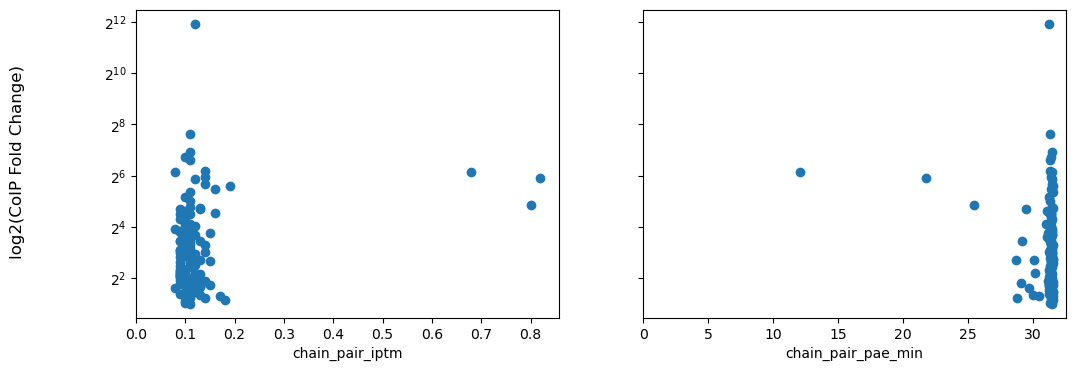

In [45]:
fig, axs = plt.subplots(1, 2, sharey=True, figsize=(12, 4))

for paired_stat, ax in zip(['chain_pair_iptm', 'chain_pair_pae_min'], axs):

    # Make a df with the experimental fold changes
    max_pair = {k: get_max_pair_metric(v, paired_stat) for k, v in summary_confidence_dicts.items()}
    to_plot_df = pd.DataFrame.from_dict(max_pair, orient='index', columns=[paired_stat]).merge(enriched, left_index=True, right_on='Accession', how='inner')
    
    ax.semilogy(to_plot_df[paired_stat], to_plot_df['Fold Change CM_vs_CMC'], 'o', base=2)
    ax.set_xlim(xmin=0)
    ax.set_xlabel(paired_stat)
    
fig.supylabel('log2(CoIP Fold Change)')

That is certainly a different looking relationship! It doesn't smack of correlation to me, but let's look at the distributions versus the random:

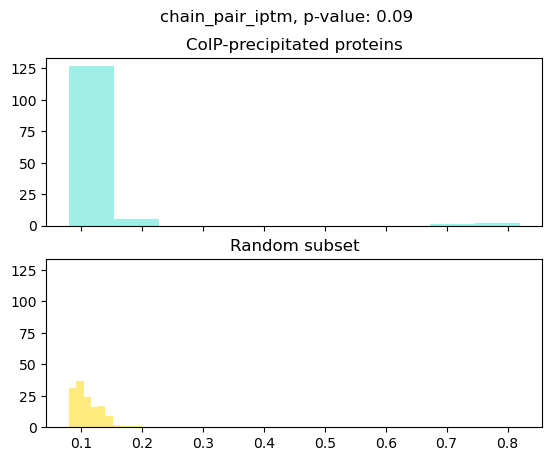

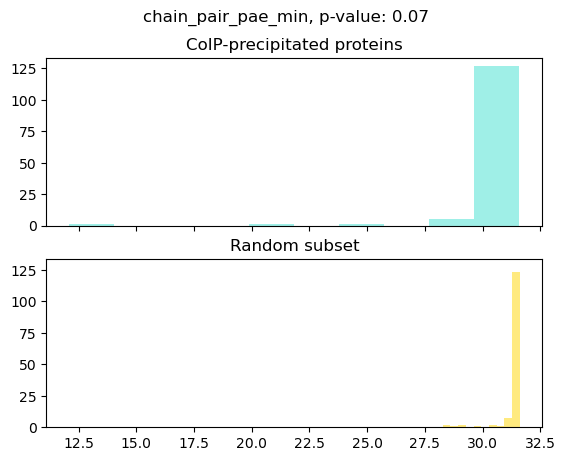

In [55]:
for paired_stat in ['chain_pair_iptm', 'chain_pair_pae_min']:

    max_pair = {k: get_max_pair_metric(v, paired_stat) for k, v in summary_confidence_dicts.items()}
    random_max_pair = {k: get_max_pair_metric(v, paired_stat) for k, v in random_summary_confidence_dicts.items()}

    fig, axs = plt.subplots(2, 1, sharex=True, sharey=True)

    axs[0].hist(max_pair.values(), color='turquoise', alpha=0.5, label=paired_stat)
    axs[0].set_title('CoIP-precipitated proteins')
    
    axs[1].hist(random_max_pair.values(), color='gold', alpha=0.5, label=paired_stat)
    axs[1].set_title('Random subset')

    pval = ttest_ind(list(max_pair.values()), list(random_max_pair.values())).pvalue

    fig.suptitle(f'{paired_stat}, p-value: {pval:.2f}')

They are significantly different, but it appears to be because of outliers. What about the non-paired metric? We just want the first value, since that is the value for chain A.

In [47]:
iptm = {k: v['chain_iptm'][0] for k, v in summary_confidence_dicts.items()}
random_iptm = {k: v['chain_iptm'][0] for k, v in random_summary_confidence_dicts.items()}

Text(0, 0.5, 'log2(CoIP Fold Change)')

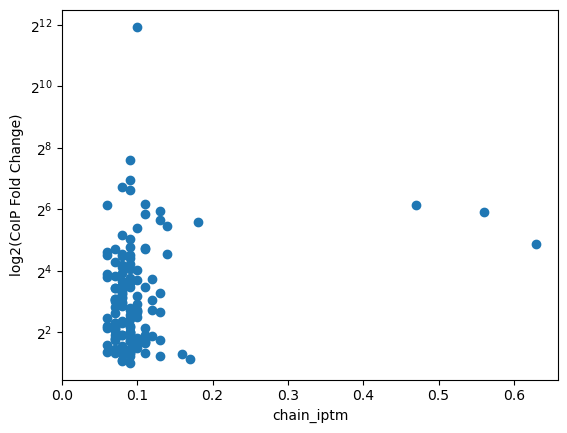

In [51]:
to_plot_df = pd.DataFrame.from_dict(iptm, orient='index', columns=['chain_iptm']).merge(enriched, left_index=True, right_on='Accession', how='inner')
plt.semilogy(to_plot_df['chain_iptm'], to_plot_df['Fold Change CM_vs_CMC'], 'o', base=2)
plt.xlim(xmin=0)
plt.xlabel('chain_iptm')
plt.ylabel('log2(CoIP Fold Change)')

Text(0.5, 0.98, 'chain_iptm, p-value: 0.08')

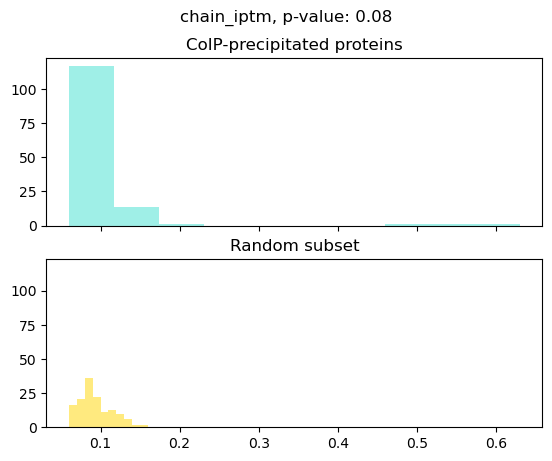

In [54]:
fig, axs = plt.subplots(2, 1, sharex=True, sharey=True)

axs[0].hist(iptm.values(), color='turquoise', alpha=0.5, label='chain_iptm')
axs[0].set_title('CoIP-precipitated proteins')

axs[1].hist(random_iptm.values(), color='gold', alpha=0.5, label='chain_iptm')
axs[1].set_title('Random subset')

pval = ttest_ind(list(iptm.values()), list(random_iptm.values())).pvalue

fig.suptitle(f'chain_iptm, p-value: {pval:.2f}')

It shows the same sort of pattern as the other two metrics. However, the goal isn't explicitly to recover all the CoIP proteins; it's to prioritize proteins for further characterization. I think this is probably best done as providing the proteins that are the top X iptm's, and let the user decide what X is. Based on this data I would reccommend `X = 5`, but I'm not sure how generalizable this finding is.

I also wonder what these outliers are in this particular case -- what proteins yield the top 5 scores?

In [62]:
top5 = sorted(iptm.items(), key=lambda item: item[1], reverse=True)[:5]
top5

[('CMV013CT', 0.63),
 ('CMV014CT', 0.56),
 ('CMF092CT', 0.47),
 ('CMQ215CT', 0.18),
 ('CML236CT', 0.17)]

CMV013CT is the rubisco large subunit, CMV014CT is the small subunit, CMF092CT is uncharacterized, CMQ215CT is Chromodomain helicase DNA binding protein CHD, and CML236CT is also uncharacterized. Quick check that the inclusion of the rubisco subnits is from the CoIP results and not from my data wrangling:

In [63]:
enriched[enriched['Accession'].isin([t[0] for t in top5])]

,Accession,Fold Change CM_vs_CMC
7,CMF092CT,70.351724
10,CMV014CT,59.539123
13,CMQ215CT,48.158952
18,CMV013CT,29.067760
137,CML236CT,2.211817


Also worth noting is that we didn't recover the highest fold change protein -- this is consistent with the lack of correlation between this metric and the fold change.